<a href="https://colab.research.google.com/github/egorssed/Simulation-based_Inference/blob/master/Notebooks/colab/LGalaxy_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install sbi --quiet
!pip install deeplenstronomy==0.0.2.0 --quiet
!pip install lenstronomy --quiet
!pip install deeplenstronomy --quiet
#!pip install getdist --quiet

#we also do this because of some compatibility issues with SBI
!pip uninstall matplotlib -y
!pip install matplotlib==3.1.3

!pip install git+https://github.com/sibirrer/fastell4py.git


# import main simulation class of lenstronomy
import deeplenstronomy.deeplenstronomy as dl
from deeplenstronomy.visualize import view_image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import os, sys
from google.colab import drive
# Change to mount '/content/drive/My Drive/Fermilab/'
drive.mount('/content/drive')
Folder='/content/drive/MyDrive/Fermilab/'

     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
     |████████████████████████████████| 3.4 MB 34.8 MB/s 
     |████████████████████████████████| 829 kB 32.7 MB/s 
     |████████████████████████████████| 11.2 MB 26.5 MB/s 
     |████████████████████████████████| 596 kB 19.9 MB/s 
     |████████████████████████████████| 895 kB 34.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Found existing installation: matplotlib 3.5.1
Uninstalling matplotlib-3.5.1:
  Successfully uninstalled matplotlib-3.5.1
     |████████████████████████████████| 13.1 MB 5.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of 

  Cloning https://github.com/sibirrer/fastell4py.git to /tmp/pip-req-build-zx2puana
  Running command git clone -q https://github.com/sibirrer/fastell4py.git /tmp/pip-req-build-zx2puana
  Created wheel for fastell4py: filename=fastell4py-0.1.0-cp37-cp37m-linux_x86_64.whl size=205877 sha256=c68b05205d0dd084c44106d16d53370d1d2f8952084152eb27fabb20c1f655f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-_gm05t3t/wheels/1c/f6/b7/0949bea0537d786e3bd69db6e13e8cd4e4e737437cfad37874
Successfully built fastell4py
Mounted at /content/drive


In [2]:
np.random.seed(42)
path_Config=Folder+'Data/Config_files_SLACS_alike/'
dataset_Park_SLACS=dl.make_dataset(path_Config+'Lenses_Park2021_HST.yaml',return_planes=True)
data_images=dataset_Park_SLACS.CONFIGURATION_1_images[:,0]
data_lens_lights=dataset_Park_SLACS.CONFIGURATION_1_planes[:,0,0]
data_source_lights=dataset_Park_SLACS.CONFIGURATION_1_planes[:,1,0]
data_noise=data_images-data_lens_lights-data_source_lights

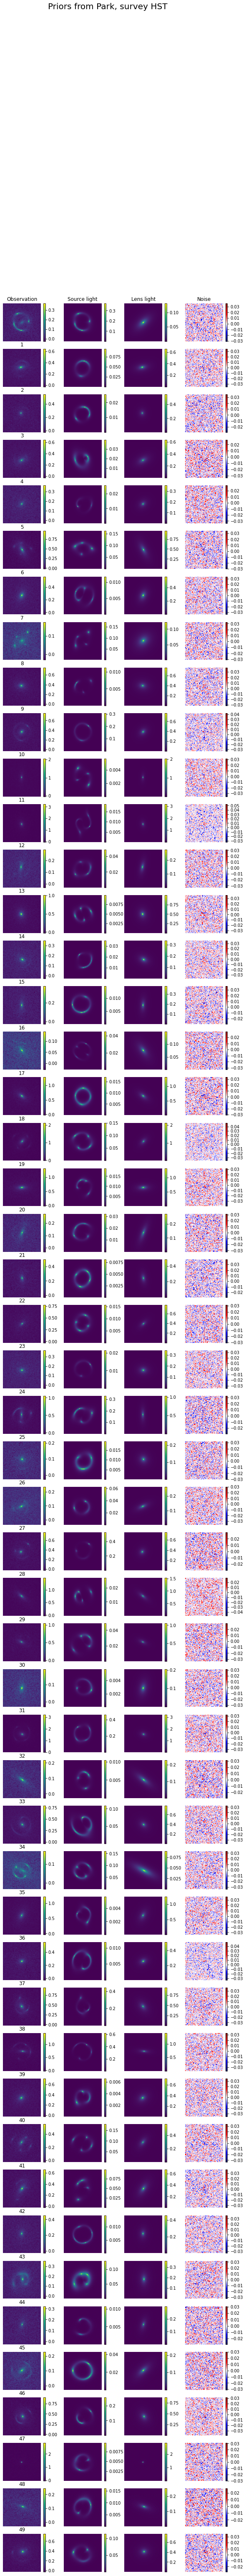

In [3]:
rows=50
fig,ax=plt.subplots(rows,4,figsize=(10,rows*2))

for i in range(rows):
  img_arr=[]
  img_arr+=[ax[i,0].imshow(data_images[i])]
  img_arr+=[ax[i,1].imshow(data_source_lights[i])]
  img_arr+=[ax[i,2].imshow(data_lens_lights[i])]
  img_arr+=[ax[i,3].imshow(data_noise[i],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]
  if i>0:
    ax[i,0].set_title(i)
  for j in range(4):
    ax[i,j].axis('off')
    fig.colorbar(img_arr[j],ax=ax[i,j],fraction=0.045)

ax[0,0].set_title('Observation')
ax[0,1].set_title('Source light')
ax[0,2].set_title('Lens light')
ax[0,3].set_title('Noise')

fig.suptitle('Priors from Park, survey HST',fontsize=20)
plt.show()

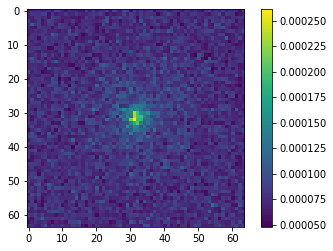

In [271]:
plt.imshow(data_noise.var(axis=0))
plt.colorbar()

# Image generation script

In [5]:
!pip install pyyaml==5.4.1

!pip install corner

import yaml
import corner

In [4]:
def define_SERSIC_ELLIPSE(magnitude,R_sersic,n_sersic,e1,e2,center_x,center_y):
  yaml_params={'R_sersic': R_sersic,'center_x': center_x,'center_y': center_y,'e1': e1,'e2': e2,'magnitude': magnitude,'n_sersic': n_sersic}
  #Cast to float
  for k, v in yaml_params.items():
    yaml_params[k] = float(v)

  yaml_config={'NAME': 'SERSIC_ELLIPSE','PARAMETERS': yaml_params}
  return yaml_config

def define_PEMD_MASS(theta_E,gamma,e1,e2,center_x,center_y):
  yaml_params={'theta_E': theta_E,'gamma': gamma,'e1': e1,'e2': e2,'e2': e2,'center_x': center_x,'center_y': center_y}

  #Cast to float
  for k, v in yaml_params.items():
    yaml_params[k] = float(v)
  
  yaml_config={'NAME': 'PEMD','PARAMETERS': yaml_params}
  return yaml_config 

def define_SHEAR(gamma_ext,psi_ext):
  yaml_params={'gamma_ext': gamma_ext,'psi_ext': psi_ext}

  #Cast to float
  for k, v in yaml_params.items():
    yaml_params[k] = float(v)

  yaml_config={'NAME': 'SHEAR_GAMMA_PSI','PARAMETERS': yaml_params}

  return yaml_config 

def define_Geometry(lens_redshift,source_redshift):
  yaml_config={'CONFIGURATION_1': {'FRACTION': 1,'NAME': 'GALAXY_AGN','NOISE_SOURCE_1': 'POISSON_NOISE',
   'PLANE_1': {'OBJECT_1': 'LENS','PARAMETERS': {'REDSHIFT': float(lens_redshift)}},
   'PLANE_2': {'OBJECT_1': 'SOURCE','PARAMETERS': {'REDSHIFT': float(source_redshift)}}}}
  return yaml_config

def draw_from_parameters(args,dataset_size=100):
  Lens_light=args[:7]
  Lens_mass=args[7:11]
  Shear=args[11:13]
  Source_light=args[13:20]
  Geometry=args[20:]

  Source_light_config=define_SERSIC_ELLIPSE(*Source_light)
  Lens_light_config=define_SERSIC_ELLIPSE(*Lens_light)

  #Lens mass and light have common center
  _,_,_,_,_,center_x,center_y=Lens_light
  theta_E,gamma,e1,e2=Lens_mass
  Lens_mass_config=define_PEMD_MASS(theta_E,gamma,e1,e2,center_x,center_y)
  Shear_config=define_SHEAR(*Shear)
  Geometry_config=define_Geometry(*Geometry)

  Full_config={'COSMOLOGY': {'PARAMETERS': {'H0': 70, 'Om0': 0.3}},
               'DATASET': {'NAME': 'fit_sampling','PARAMETERS': {'OUTDIR': 'fit_sampling', 'SIZE': dataset_size}},
               'IMAGE': {'PARAMETERS': {'ccd_gain': 2.5, 'exposure_time': 2028.0, 'numPix': 64, 'pixel_scale': 0.08,
                                        'psf_type': 'GAUSSIAN', 'read_noise': 4}},
               'SURVEY': {'PARAMETERS': {'BANDS': 'F814W','magnitude_zero_point': 21.659,
                                         'num_exposures': 1,'seeing': 0.08,'sky_brightness': 22.9}},
               'GEOMETRY': Geometry_config,
               'SPECIES': {'GALAXY_1': {'NAME': 'LENS',
                                        'LIGHT_PROFILE_1': Lens_light_config,
                                        'MASS_PROFILE_1': Lens_mass_config,
                                        'SHEAR_PROFILE_1': Shear_config},
                           'GALAXY_2': {'NAME': 'SOURCE',
                                        'LIGHT_PROFILE_1': Source_light_config,
                                        'MASS_PROFILE_1': {'NAME': 'SIE','PARAMETERS': 
                                                           {'center_x': 0.0,'center_y': 0.0,'e1': 0.1,'e2': -0.1,'theta_E': 2.0}}},
                           'NOISE_1': {'NAME': 'POISSON_NOISE', 'PARAMETERS': {'mean': 0.0}}}
               }


  # The functionality with passing dict doesn't work, so need to write
  Tempfile_name=Folder+'Data/Config_files_SLACS_alike/temp/config.yaml'
  with open(Tempfile_name, 'w') as f:
    _ = yaml.dump(Full_config, f,default_flow_style=False)

  dataset=dl.make_dataset(Tempfile_name)

  return dataset.CONFIGURATION_1_images

def args2kwargs(args):
  Lens_light=args[:7]
  Lens_mass=args[7:11]
  Shear=args[11:13]
  Source_light=args[13:20]
  Geometry=args[20:]
    
  Source_light_kwarg_names=['SL_magnitude','SL_R_sersic','SL_n_sersic','SL_e1','SL_e2','SL_center_x','SL_center_y']
  Source_light_kwargs={name:Source_light[i] for i,name in enumerate(Source_light_kwarg_names)}

  Lens_light_kwarg_names=['LL_magnitude','LL_R_sersic','LL_n_sersic','LL_e1','LL_e2','L_center_x','L_center_y']
  Lens_light_kwargs={name:Lens_light[i] for i,name in enumerate(Lens_light_kwarg_names)}

  Lens_mass_kwarg_names=['LM_theta_E','LM_gamma','LM_e1','LM_e2']
  Lens_mass_kwargs={name:Lens_mass[i] for i,name in enumerate(Lens_mass_kwarg_names)}

  Shear_kwargs={'gamma_ext': Shear[0],'psi_ext': Shear[1]}
  Geometry_kwargs={'lens_redshift':Geometry[0],'source_redshift':Geometry[1]}

  return Lens_light_kwargs,Lens_mass_kwargs,Shear_kwargs,Source_light_kwargs,Geometry_kwargs

def kwargs2args(Lens_light_kwargs,Lens_mass_kwargs,Shear_kwargs,Source_light_kwargs,Geometry_kwargs):
  args=np.zeros(22)

  Lens_light_kwarg_names=['LL_magnitude','LL_R_sersic','LL_n_sersic','LL_e1','LL_e2','L_center_x','L_center_y']
  args[:7]=[Lens_light_kwargs[name] for name in Lens_light_kwarg_names]

  Lens_mass_kwarg_names=['LM_theta_E','LM_gamma','LM_e1','LM_e2']
  args[7:11]=[Lens_mass_kwargs[name] for name in Lens_mass_kwarg_names]

  Source_light_kwarg_names=['SL_magnitude','SL_R_sersic','SL_n_sersic','SL_e1','SL_e2','SL_center_x','SL_center_y']
  args[13:20]=[Source_light_kwargs[name] for name in Source_light_kwarg_names]

  args[11:13]=[Shear_kwargs['gamma_ext'],Shear_kwargs['psi_ext']]
  args[20:]=[Geometry_kwargs['lens_redshift'],Geometry_kwargs['source_redshift']]

  return args

## Constrain with priors

In [6]:
def within_prior(value,parameter0,parameter1,prior='normal'):
  if prior=='normal':
    #within 3sigmas
    return (value<parameter0+3*parameter1) and (value>parameter0-3*parameter1)
  if prior=='uniform':
    return (value<parameter0) and (value>parameter1)
  else:
    raise ValueError

def constrain_args(args):
  correct_lens_light=within_prior(args[0],19.,17.,'uniform') and within_prior(args[1],0.8,0.15) and within_prior(args[2],3.,0.55) and \
    within_prior(args[3],0.,0.2) and within_prior(args[4],0.,0.2) and within_prior(args[5],0.,0.07) and within_prior(args[6],0.,0.07)

  correct_lens_mass=within_prior(args[7],1.1,0.1) and within_prior(args[8],2.0,0.1) and within_prior(args[9],0.,0.2)  and within_prior(args[10],0.,0.2)

  correct_shear= within_prior(args[11],0.05,0.,'uniform') and within_prior(args[12],np.pi/2,-np.pi/2,'uniform')

  correct_source_light=within_prior(args[13],25.,20.,'uniform') and within_prior(args[14],0.35,0.05) and within_prior(args[15],3.,0.5) and \
    within_prior(args[16],0.,0.2) and within_prior(args[17],0.,0.2) and within_prior(args[18],0.2,-0.2,'uniform') and within_prior(args[19],0.2,-0.2,'uniform')

  # Source further than lens, priors on source, priors on lens, redshifts not negative
  correct_geometry=(args[-1]>args[-2]) and within_prior(args[-1],2.,0.4,'normal') and within_prior(args[-2],0.5,0.2,'normal') and \
    (args[-1]>0) and (args[-2]>0)

  return correct_lens_light,correct_lens_mass,correct_shear,correct_source_light,correct_geometry

def prior(value,parameter0,parameter1,prior='normal'):
  if prior=='normal':
    #within 3sigmas
    return np.exp(-0.5*np.power((value-parameter0)/parameter1,2))/(np.sqrt(2*np.pi)*parameter1)
  if prior=='uniform':
    return ((value<parameter0) and (value>parameter1)).astype(float)/(parameter0-parameter1)
  else:
    raise ValueError

def prior_on_args(args):

  prior_source_light=prior(args[13],25.,20.,'uniform')*prior(args[14],0.35,0.05)*prior(args[15],3.,0.5)*prior(args[16],0.,0.2)*prior(args[17],0.,0.2)*prior(args[18],0.2,-0.2,'uniform')*prior(args[19],0.2,-0.2,'uniform')

  prior_lens_light=prior(args[0],19.,17.,'uniform')*prior(args[1],0.8,0.15)*prior(args[2],3.,0.55)*prior(args[3],0.,0.2)*prior(args[4],0.,0.2)*prior(args[5],0.,0.07)*prior(args[6],0.,0.07)


  prior_lens_mass=prior(args[7],1.1,0.1)*prior(args[8],2.0,0.1)*prior(args[9],0.,0.2)*prior(args[10],0.,0.2)

  prior_shear=prior(args[11],0.05,0.,'uniform')*prior(args[12],np.pi/2,-np.pi/2,'uniform')

  # Source further than lens, priors on source, priors on lens, redshifts not negative
  correct_geometry=(args[-1]>0) and (args[-2]>0) and (args[-1]>args[-2])
  prior_geometry=correct_geometry.astype(float)*prior(args[-1],2.,0.4,'normal')*prior(args[-2],0.5,0.2,'normal')

  #print(prior_source_light,prior_lens_light,prior_lens_mass,prior_shear)
  return prior_source_light*prior_lens_light*prior_lens_mass*prior_shear*prior_geometry


## Sample from prior

In [7]:
def sample_args(random_seed):
  rng = np.random.default_rng(random_seed)
  Source_light_args=np.zeros(7)
  Lens_light_args=np.zeros(7)
  Lens_mass_args=np.zeros(4)
  Shear_args=np.zeros(2)
  Geometry_args=np.zeros(2)

  Source_light_args[0]=rng.uniform(20,25) #magnitude
  Source_light_args[1:5]=rng.normal(loc=[0.35,3.,0.,0.],scale=[0.05,0.5,0.2,0.2]) #R,n,e1,e2
  Source_light_args[5:7]=rng.uniform(-0.2,0.2,size=2) #center
  
  Lens_light_args[0]=rng.uniform(17,19) #magnitude
  Lens_light_args[1:]=rng.normal(loc=[0.8,3.,0.,0.,0.,0.],scale=[0.15,0.55,0.2,0.2,0.07,0.07])

  Lens_mass_args=rng.normal(loc=[1.1,2.,0.,0.],scale=[0.1,0.1,0.2,0.2])

  Shear_args=rng.uniform(low=[0.,-np.pi/2],high=[0.05,np.pi/2])

  correct_geometry=False
  while not correct_geometry:
    Geometry_args=rng.normal(loc=[0.5,2.],scale=[0.2,0.4])
    correct_geometry=(Geometry_args[1]>0) and (Geometry_args[0]>0) and (Geometry_args[1]>Geometry_args[0])
  
  return np.concatenate((Lens_light_args,Lens_mass_args,Shear_args,Source_light_args,Geometry_args))


In [8]:
LL_middle_args=[18.,0.8,3.,0.,0.,0.,0.]
LM_middle_args=[1.1,2.,0.,0.]
Shear_middle_args=[0.025,0.]
SL_middle_args=[22.5,0.35,3.,0.,0.,0.,0.]
Geometry_middle_args=[0.5,2.]
Full_middle_args=np.array(LL_middle_args+LM_middle_args+Shear_middle_args+SL_middle_args+Geometry_middle_args)
# Bijection check
kwargs2args(*args2kwargs(Full_middle_args))==Full_middle_args

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [9]:
mock_images=draw_from_parameters(Full_middle_args,dataset_size=100)

In [10]:
mock_images.shape

(100, 1, 64, 64)

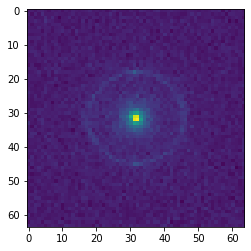

In [11]:
plt.imshow(mock_images[0,0])

# Test fitting

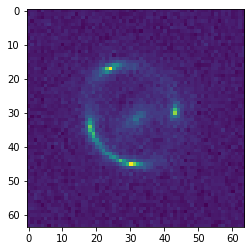

In [12]:
plt.imshow(data_images[0])

In [13]:
data_image=data_images[0]
model_images_number=100

In [28]:
def SBI_log_likelihood(args,data_image,model_images_number=100):
  model_images=draw_from_parameters(args,dataset_size=model_images_number)
  #single channel image
  model_images=model_images[:,0,:,:]

  mean_image=model_images.mean(axis=0)
  var_image=model_images.var(axis=0)

  Chi_squared=-0.5*(data_image-mean_image)**2/var_image
  Normalisation_factor=-0.5*np.log(2*np.pi*var_image)

  return Chi_squared.sum()+Normalisation_factor.sum()

# log-likelihood (-chi^2) and log-priors
def log_prob(args,data_image,model_images_number):
  log_prior=np.log(prior_on_args(args))
  if np.isinf(log_prior):
    #print('wrong geometry')
    return log_prior
  log_likelihood=SBI_log_likelihood(args,data_image,model_images_number)
  
  #print(' log-posterior={:.3f} log-likelihood={:.3f} log-prior={:.3f}'.format(log_likelihood+log_prior,log_likelihood,log_prior))
  return log_likelihood+log_prior

def loss_function(args,data_image,model_images_number):
  return -log_prob(args,data_image,model_images_number)

In [392]:
SBI_log_likelihood(Full_middle_args,data_image,model_images_number)

(-3512.6815344684487, 15605.46237852098)

In [15]:
#No numba
%timeit SBI_log_likelihood(Full_middle_args,data_image,model_images_number)

1 loop, best of 5: 1.1 s per loop


In [16]:
import scipy

In [381]:
Nfeval = 1
history=np.zeros((0,22))
loss_history=np.zeros(0)

data_image=data_images[5]
model_images_number=100
initial_args=Full_middle_args+1e-3

def callbackF(Xi):
    #print(optimizer.fun)
    global Nfeval
    global history
    global loss_history
    loss=loss_function(Xi,data_image,model_images_number)
    print('{0:4d}   {1:3.6f}'.format(Nfeval, loss))
    Nfeval += 1
    loss_history=np.append(loss_history,loss)
    history=np.append(history,[Xi],axis=0)



res=scipy.optimize.minimize(loss_function,initial_args,args=(data_image,model_images_number),method='Nelder-Mead',options={'disp': True},callback=callbackF)

 log-posterior=12077.470 log-likelihood=12062.502 log-prior=14.968
 log-posterior=10608.012 log-likelihood=10593.044 log-prior=14.968
 log-posterior=12150.548 log-likelihood=12135.599 log-prior=14.949
 log-posterior=12113.362 log-likelihood=12098.414 log-prior=14.949
 log-posterior=12118.186 log-likelihood=12103.219 log-prior=14.968
 log-posterior=12084.386 log-likelihood=12069.418 log-prior=14.968
 log-posterior=12119.353 log-likelihood=12104.385 log-prior=14.968
 log-posterior=12094.757 log-likelihood=12079.789 log-prior=14.968


KeyboardInterrupt: ignored

In [ ]:
#np.savez(Folder+'Data/Config_files_SLACS_alike/temp/fit_history',args_history=history,loss_history=loss_history)

In [ ]:
arr=np.load(Folder+'Data/Config_files_SLACS_alike/temp/fit_history.npz')
history=arr['args_history']
loss_history=arr['loss_history']

In [ ]:
# начал фит в 15:35
# 704 шага за 55 минут

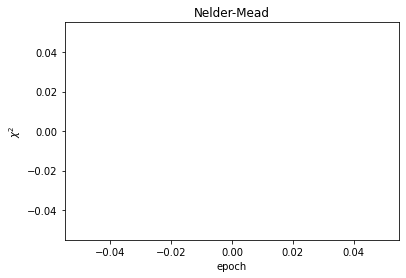

In [377]:
plt.plot(loss_history)
plt.ylabel(r'$\chi^2$')
plt.xlabel('epoch')
plt.title('Nelder-Mead')
plt.show()

197

In [ ]:
best_fit_images=draw_from_parameters(history[np.argmin(loss_history)],dataset_size=model_images_number)

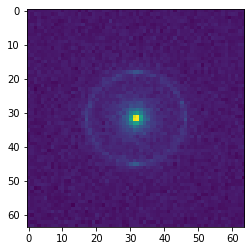

In [ ]:
plt.imshow(best_fit_images[0,0])

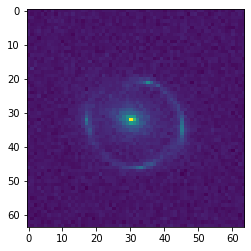

In [ ]:
plt.imshow(data_image)

In [ ]:
args2kwargs(history[197])

({'LL_R_sersic': 0.8122799800822216,
  'LL_e1': 0.0010024984136842953,
  'LL_e2': 0.0010412631748222528,
  'LL_magnitude': 17.673754930346252,
  'LL_n_sersic': 3.0132659781214493,
  'L_center_x': 0.0009896149786244634,
  'L_center_y': 0.001014618838214815},
 {'LM_e1': 0.0010171109498490413,
  'LM_e2': 0.0010255857182944797,
  'LM_gamma': 1.8167982501510105,
  'LM_theta_E': 1.1073349020117251},
 {'gamma_ext': 0.02619051857007501, 'psi_ext': 0.0010206957410477187},
 {'SL_R_sersic': 0.35143601793627716,
  'SL_center_x': 0.001001092277936108,
  'SL_center_y': 0.001027098556519081,
  'SL_e1': 0.0010009248959097243,
  'SL_e2': 0.0009696787589551547,
  'SL_magnitude': 22.137205958257624,
  'SL_n_sersic': 3.0109238991958893},
 {'lens_redshift': 0.5099012697999321, 'source_redshift': 1.984158522324696})

# Test MCMC

In [17]:
!pip install emcee

import emcee

     |████████████████████████████████| 45 kB 1.8 MB/s 


In [21]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-450bd7e5-adfb-3377-6d2a-c619e0ff5460)


In [25]:
import os

os.environ["OMP_NUM_THREADS"] = "44"

In [26]:
ndim= 22
nwalkers=44
#TODO random sampling of deviation from starting point
p0=np.array([sample_args(i+1) for i in range(nwalkers)])

In [29]:
np.random.seed(42)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[data_image,model_images_number])
# shape should be (nwalkers,ndims) but with some random np.repeat(p0,100).reshape((100,22)).T
state=sampler.run_mcmc(p0, 10, progress=True)

100%|██████████| 10/10 [06:30<00:00, 39.06s/it]


In [34]:
del yaml

     |████████████████████████████████| 636 kB 5.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
deeplenstronomy 0.0.2.0 requires matplotlib>=3.3.2, but you have matplotlib 3.1.3 which is incompatible.


In [36]:
import yaml

In [37]:
import corner

TypeError: ignored

In [30]:
flat_samples = sampler.get_chain(flat=True)



TypeError: ignored

In [31]:
np.savez(Folder+'Data/Config_files_SLACS_alike/temp/fit_history',args_history=history,loss_history=loss_history)

TypeError: ignored

In [ ]:

fig = corner.corner(flat_samples)

In [ ]:
# decide on some scatter to initialize emcee walkers
kwargs_std = {
    'kwargs_lens': [{'theta_E': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1}, {'gamma1': 0.1, 'gamma2': 0.1}],
    'kwargs_source': [{}], 
}
init_stds = parameters.kwargs2args(kwargs_std)

# here we need to define a non-jitted log-likelihood function
def log_likelihood_nojit(args):
    # Compute reconstruction with these parameters
    rec = lens_image.model(**parameters.args2kwargs(args))
    noise_var = lens_image.Noise.C_D
    # log-likelihood
    log_l = - 0.5 * jnp.sum((data - rec)**2 / noise_var)
    # log-prior
    log_l += parameters.log_prior_nojit(args)
    return log_l

samples_mcmc, logL_mcmc, extra_fields_mcmc, runtime \
    = sampler.mcmc(log_likelihood_nojit, init_stds, 
                   walker_ratio=10, num_warmup=100, num_samples=100, 
                   restart_from_init=False)
print(f"Runtime: {runtime}")
print(f"Samples shape: {samples_mcmc.shape}")

In [ ]:
history[197]

array([1.76737549e+01, 8.12279980e-01, 3.01326598e+00, 1.00249841e-03,
       1.04126317e-03, 9.89614979e-04, 1.01461884e-03, 1.10733490e+00,
       1.81679825e+00, 1.01711095e-03, 1.02558572e-03, 2.61905186e-02,
       1.02069574e-03, 2.21372060e+01, 3.51436018e-01, 3.01092390e+00,
       1.00092490e-03, 9.69678759e-04, 1.00109228e-03, 1.02709856e-03,
       5.09901270e-01, 1.98415852e+00])

In [ ]:
Full_middle_args+1e-3

array([1.8001e+01, 8.0100e-01, 3.0010e+00, 1.0000e-03, 1.0000e-03,
       1.0000e-03, 1.0000e-03, 1.1010e+00, 2.0010e+00, 1.0000e-03,
       1.0000e-03, 2.6000e-02, 1.0000e-03, 2.2501e+01, 3.5100e-01,
       3.0010e+00, 1.0000e-03, 1.0000e-03, 1.0000e-03, 1.0000e-03,
       5.0100e-01, 2.0010e+00])

In [ ]:
res.fun

1.3368342479391215

In [ ]:
res.x

array([ 1.80000000e+01,  7.99999990e-01,  2.99999999e+00, -3.07366362e-08,
       -1.52889606e-08, -2.32746592e-08, -1.31636397e-08,  1.10000003e+00,
        2.00000000e+00, -2.03090864e-14,  6.69046699e-09,  2.49999904e-02,
       -7.02158725e-09,  2.25000000e+01,  3.49999985e-01,  2.99999998e+00,
       -1.31636334e-08,  3.12628324e-08, -3.65596649e-09,  2.01592281e-14,
        5.00000007e-01,  1.99999999e+00])

In [ ]:
Full_middle_args

array([18.   ,  0.8  ,  3.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.1  ,
        2.   ,  0.   ,  0.   ,  0.025,  0.   , 22.5  ,  0.35 ,  3.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.5  ,  2.   ])